In [120]:
DATASET_COMMON_FOLDER = "/mnt/workspace/imageclef/2020-2021-Datasets/VQA/"
TEST_2021_IMAGES = DATASET_COMMON_FOLDER + "VQA-500-Images/"
TEST_2021_QUESTIONS = DATASET_COMMON_FOLDER + "Task1-VQA-2021-TestSet-Questions.txt"
TEST_2021_ANSWERS = DATASET_COMMON_FOLDER + "Task1-VQA-2021-TestSet-ReferenceAnswers.txt"

In [121]:
import pandas as pd
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pickle
from PIL import Image

In [122]:
test_2021_answers = pd.read_csv(TEST_2021_ANSWERS, sep="|", header=None)

In [123]:
len(test_2021_answers)

500

In [124]:
def preprocess_test_answers(df):
    token_regex = re.compile(r'[a-z\-\']+|[(),]')
    id2answer = dict()
    for i in range(len(df)):
        _id = df[0][i]
        answer = ''
        for j in range(1,4):
            if type(df[j][i]) == str:
                if answer: answer += ', '
                answer += df[j][i]
        id2answer[_id] = token_regex.findall(answer)
    return id2answer

In [125]:
def load_questions(path):
    df = pd.read_csv(path, sep="|", header=None)    
    id2questions = dict()
    for i in range(len(df)):
        id2questions[df[0][i]] = df[1][i]
    return id2questions

In [126]:
def load_pred_answers(path):
    df = pd.read_csv(path, sep="|", header=None)    
    id2answer = dict()
    for i in range(len(df)):
        id2answer[df[0][i]] = df[1][i].split()
    return id2answer

In [127]:
gt_id2answer = preprocess_test_answers(test_2021_answers)

In [128]:
gt_id2question = load_questions(TEST_2021_QUESTIONS)

In [43]:
pred_id2answer = load_pred_answers('./results_v2.txt')

In [47]:
print(len(pred_id2answer), len(gt_id2answer))
assert len(gt_id2answer.keys() & pred_id2answer.keys()) == len(pred_id2answer.keys())

500 500


In [73]:
def compute_bleu(reference, hypothesis, smoothing_function):
    return 0 if len(hypothesis) == 0 else sentence_bleu((reference,), hypothesis,
                                                            smoothing_function=smoothing_function, auto_reweigh=True)

In [95]:
def compute_nlp_metrics(gt_id2answer, pred_id2answer, smoothing_function):
    total_bleu = 0
    exact_matches = 0
    n = len(gt_id2answer)
    id_bleu_pairs = []
    for _id in gt_id2answer.keys():
        reference = gt_id2answer[_id]
        hypothesis = pred_id2answer[_id]
        bleu = compute_bleu(reference, hypothesis, smoothing_function)
        total_bleu += bleu
        if bleu == 1:
            exact_matches += 1
        id_bleu_pairs.append((_id, bleu))
    return total_bleu/n, exact_matches/n, id_bleu_pairs

In [96]:
out = compute_nlp_metrics(gt_id2answer, pred_id2answer, None)
print(out[0], out[1])

0.008008173542876928 0.008


In [100]:
id_bleu_pairs = out[2]
id_bleu_pairs.sort(key = lambda p:p[1])
sorted_test_ids = [p[0] for p in id_bleu_pairs]

In [55]:
with open('./imageclef_2021_vqa_challenge__test_id2output.pickle', 'rb') as f:
    pred_id2output = pickle.load(f)

In [77]:
def inspect_predictions(_id):
    print('gt_question:', gt_id2question[_id])
    print('pred_question:', pred_id2output[_id]['pred_question'])
    print('-----')
    print('gt_answer:', ' '.join(gt_id2answer[_id]))
    print('pred_answer:', ' '.join(pred_id2output[_id]['pred_answer']))
    print('bleu:', compute_bleu(gt_id2answer[_id], pred_id2output[_id]['pred_answer'], None))
    print('-----')
    print('pred_type:', pred_id2output[_id]['pred_type'])
    print('pred_labels:', pred_id2output[_id]['pred_labels'])
    return Image.open(TEST_2021_IMAGES + _id + '.jpg').reduce(3)

gt_question: what abnormality is seen in the image?
pred_question: what abnormality is seen in the image
-----
gt_answer: avascular necrosis , extensive degenerative changes on the bilateral femoral heads and acetabula , vascular ecrosis of femoral heads bilaterally with associated osteoarthritic changes
pred_answer: adenomyosis
bleu: 0
-----
pred_type: mri
pred_labels: []


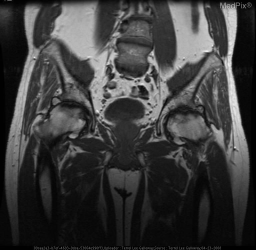

In [119]:
inspect_predictions(sorted_test_ids[0])